In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd

ENTRY = 'input'
BASE_DIR = f'{ENTRY}/nfl-health-and-safety-helmet-assignment'

mypath = 'input/nfl-health-and-safety-helmet-assignment/test/'
# mypath = 'input/nfl-health-and-safety-helmet-assignment/train/'
onlyfiles = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
pd.DataFrame(onlyfiles).to_clipboard()

# Аннотируем видео в картинку 3на3

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from helmet_assignment.video import video_with_predictions
from IPython.display import Video, display
from helmet_assignment.score import NFLAssignmentScorer, check_submission
from helmet_assignment.features import add_track_features
import sys
from PIL import Image


def find_nearest(array, value):
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def create_football_field(
    linenumbers=True,
    endzones=True,
    highlight_line=False,
    highlight_line_number=50,
    highlighted_name="Line of Scrimmage",
    fifty_is_los=False,
    figsize=(12, 6.33),
    field_color="lightgreen",
    ez_color='forestgreen',
    ax=None,):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle(
        (0, 0),
        120,
        53.3,
        linewidth=0.1,
        edgecolor="r",
        facecolor=field_color,
        zorder=0,
    )

    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='black')

    if fifty_is_los:
        ax.plot([60, 60], [0, 53.3], color="gold")
        ax.text(62, 50, "<- Player Yardline at Snap", color="gold")
    # Endzones
    if endzones:
        ez1 = patches.Rectangle(
            (0, 0),
            10,
            53.3,
            linewidth=0.1,
            edgecolor="black",
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ez2 = patches.Rectangle(
            (110, 0),
            120,
            53.3,
            linewidth=0.1,
            edgecolor="black",
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    ax.axis("off")
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            ax.text(
                x,
                5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color="black",
            )
            ax.text(
                x - 0.95,
                53.3 - 5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color="black",
                rotation=180,
            )
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color="black")
        ax.plot([x, x], [53.0, 52.5], color="black")
        ax.plot([x, x], [22.91, 23.57], color="black")
        ax.plot([x, x], [29.73, 30.39], color="black")

    if highlight_line:
        hl = highlight_line_number + 10
        ax.plot([hl, hl], [0, 53.3], color="yellow")
        ax.text(hl + 2, 50, "<- {}".format(highlighted_name), color="yellow")

    border = patches.Rectangle(
        (-5, -5),
        120 + 10,
        53.3 + 10,
        linewidth=0.1,
        edgecolor="orange",
        facecolor="white",
        alpha=0,
        zorder=0,
    )
    ax.add_patch(border)
    ax.set_xlim((0, 120))
    ax.set_ylim((0, 53.3))
    return ax


def plot_one_box(x, im, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label: 
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return im

if os.environ['PWD'] == '/':
    ENTRY = 'input' # local run
if os.environ['PWD'] == '/kaggle/working':
    ENTRY = '../input' # kaggle run

BASE_DIR = f'{ENTRY}/nfl-health-and-safety-helmet-assignment'

for part in ['/train', '/test']:
    tracking = pd.read_csv(f'{BASE_DIR}{part}_player_tracking.csv')
    tracking = add_track_features(tracking)

    helmets = pd.read_csv(f'{BASE_DIR}{part}_baseline_helmets.csv')
    helmets['video'] = helmets['video_frame'].apply(lambda x: '_'.join(x.split('_')[:3]))
    helmets['frame'] = helmets['video_frame'].apply(lambda x: int(x.split('_')[-1]))
    helmets['right'] = helmets['left'] + helmets['width']
    helmets['down'] = helmets['top'] + helmets['height']
    helmets['game_play'] = helmets['video'].apply(lambda x: '_'.join(x.split('_')[0:2]))
    helmets['view'] = helmets['video'].apply(lambda x: x.split('_')[2])

    mypath = BASE_DIR + part
    gameplays = sorted(helmets['game_play'].unique())
    for gameplay in gameplays: # перебираем видео
        total_frames_min = helmets[helmets['game_play'] == gameplay].drop_duplicates(['frame', 'view']).drop_duplicates('view', keep='last').frame.min()
        frames_print = [1, int(total_frames_min/2), total_frames_min]

        merge_frames = []
        for frame in frames_print: # перебираем кадры
            merge_views = []
            for view in ['Endzone', 'Sideline']:
                video_path = f'{mypath}/{gameplay}_{view}.mp4'
                cap = cv2.VideoCapture(video_path) # обращаемся к видеофайлу
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # Устанавливаем индекс кадра, который будет извлекаться из видеопотока (индексация начинается от 0)
                success, image = cap.read() # Считываем кадр(картинку) , метод возвращает флаг success (True , False) и image — саму картинку (массив numpy)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Меняем цветовое пространство на RGB
                output = helmets[(helmets['game_play'] == gameplay) & (helmets['view'] == view) & (helmets['frame'] == frame)]

                for x in output.loc[:,['left', 'top', 'right','down']].values: # перебираем шлемы
                    bboxes = list(x)
                    # id = frame
                    label = 'V'
                    im = plot_one_box(bboxes, image, label=label,
                                    #   color=(171, 6, 75), 
                                      color=(188, 19, 254), 
                                      line_thickness=2)
                fig, ax = plt.subplots(figsize=(17.5, 12))
                filename = gameplay+ '_' + str(frame) +'_'+view +'.jpg'
                ax.set_title(filename)
                plt.imshow(im)
                image_folder = 'videos_annotation'+part
                plt.savefig(image_folder+'/'+filename,dpi = 100)
                plt.close(fig)
                merge_views += [image_folder+'/'+filename]
            
            tracking_this_video = tracking[(tracking['game_play'] == gameplay)]
            nearest_frame_tracking = find_nearest(tracking_this_video['est_frame'].values, frame) # Находим предполагаемый кадр из трека по номеру кадра
            example_tracks =  tracking_this_video.loc[tracking_this_video['est_frame'] == nearest_frame_tracking]
            ax = create_football_field(figsize=(22.8, 12)) # figsize=(12, 6.33)
            for team, d in example_tracks.groupby("team"):
                ax.scatter(d["x"], d["y"], label=team, s=65, lw=1, edgecolors="black", zorder=5)
            ax.legend().remove()
            filename = gameplay  + '_' + str(frame) + '_Track'+'.jpg'
            ax.set_title(filename, fontsize=15)
            plt.savefig(image_folder+'/'+filename,dpi = 100)
            plt.close()
            merge_views += [image_folder+'/'+filename]

            # append videos for merge_veiws
            images = [Image.open(x) for x in merge_views]
            widths, heights = zip(*(i.size for i in images))
            total_width = sum(widths)
            max_height = max(heights)
            new_im = Image.new('RGB', (total_width, max_height))
            x_offset = 0
            for im in images:
                new_im.paste(im, (x_offset,0))
                x_offset += im.size[0]
            new_im.save(image_folder+'_merge_views/' + gameplay+'_'+str(frame)+'_EST.jpg')

            merge_frames += merge_views
        
        # append videos for merge_frames
        images = [Image.open(x) for x in merge_frames]
        widths, heights = zip(*(i.size for i in images))
        total_width = int(sum(widths)/3)
        total_height = int(sum(heights)/3)

        new_im = Image.new('RGB', (total_width, total_height))
        x_offset = 0
        y_offset = 0
        for im in range(len(images)):
            img = images[im]
            if ((im+1)%3) != 0 :
                new_im.paste(img, (x_offset,y_offset))
                x_offset += img.size[0]
            else:
                new_im.paste(img, (x_offset,y_offset))
                x_offset = 0
                y_offset += img.size[1]
            
        new_im.save(image_folder+'_merge_frames/' + gameplay+'_EST_all.jpg')
                

# Оставляем 10 разнообразных видосов

In [1]:
import pandas as pd

ll = pd.read_csv('videos_annotation/table.csv')
ll['sum'] = ll.sum(axis=1)
ll = ll.loc[ll['part'] == 'train']

ll['code'] = ll['Положение игроков на поле'].astype('str') + ll['Поле+бровка+трибуны'].astype('str') + ll['Лишние боксы'].astype('str') + ll['Плотно расположены'].astype('str') +  ll['Бегут на фланг'].astype('str')
show = ll.sort_values('code').drop_duplicates(['Положение игроков на поле','Поле+бровка+трибуны','Лишние боксы']).sort_values(['Бегут на фланг','Положение игроков на поле','Поле+бровка+трибуны'], ascending=False)
show.loc[:,['game_play','part','Положение игроков на поле','Поле+бровка+трибуны','Лишние боксы','Плотно расположены','Бегут на фланг','sum','code']].to_clipboard()

# Видео с предсказаниями

In [2]:
from helmet_assignment.video import video_with_predictions
from IPython.display import Video, display
from helmet_assignment.score import NFLAssignmentScorer, check_submission
from helmet_assignment.features import add_track_features

submission_deepsort = pd.read_csv('input/submission_0p68.csv')
labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')

submission_deepsort['video'] = submission_deepsort['video_frame'].str.split('_').str[:3].str.join('_') + '.mp4'
debug_videos = submission_deepsort['video'].unique()
debug_labels = labels.query('video in @debug_videos')
scorer = NFLAssignmentScorer(debug_labels)
scorer.score(submission_deepsort)

# Create video showing predictions for one of the videos.
video_out = video_with_predictions(f'{BASE_DIR}/train/{debug_videos[0]}',
                                    scorer.sub_labels)

frac = 0.60 # scaling factor for display
display(Video(data=video_out,embed=False,height=int(720*frac),width=int(1280*frac)))

Running for 57787_003413_Endzone


ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil    

# Plotly Field

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly
if os.environ['PWD'] == '/':
    ENTRY = 'input' # local run
    plotly.io.renderers.default = "notebook_connected"
if os.environ['PWD'] == '/kaggle/working':
    ENTRY = '../input' # kaggle run

def add_plotly_field(fig):
    # Reference https://www.kaggle.com/ammarnassanalhajali/nfl-big-data-bowl-2021-animating-players
    fig.update_traces(marker_size=20)
    
    fig.update_layout(paper_bgcolor='#29a500', plot_bgcolor='#29a500', font_color='white',
        width = 800,
        height = 600,
        title = "",
        
        xaxis = dict(
        nticks = 10,
        title = "",
        visible=False
        ),
        
        yaxis = dict(
        scaleanchor = "x",
        title = "Temp",
        visible=False
        ),
        showlegend= True,
  
        annotations=[
       dict(
            x=-5,
            y=26.65,
            xref="x",
            yref="y",
            text="ENDZONE",
            font=dict(size=16,color="#e9ece7"),
            align='center',
            showarrow=False,
            yanchor='middle',
            textangle=-90
        ),
        dict(
            x=105,
            y=26.65,
            xref="x",
            yref="y",
            text="ENDZONE",
            font=dict(size=16,color="#e9ece7"),
            align='center',
            showarrow=False,
            yanchor='middle',
            textangle=90
        )]  
        ,
        legend=dict(
        traceorder="normal",
        font=dict(family="sans-serif",size=12),
        title = "",
        orientation="h",
        yanchor="bottom",
        y=1.00,
        xanchor="center",
        x=0.5
        ),
    )
    ####################################################
        
    fig.add_shape(type="rect", x0=-10, x1=0,  y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#217b00" ,layer="below")
    fig.add_shape(type="rect", x0=100, x1=110, y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#217b00" ,layer="below")
    for x in range(0, 100, 10):
        fig.add_shape(type="rect", x0=x,   x1=x+10, y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#29a500" ,layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=1, x1=x, y1=2,line=dict(color="#c8ddc0",width=2),layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=51.3, x1=x, y1=52.3,line=dict(color="#c8ddc0",width=2),layer="below")
    
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=20.0, x1=x, y1=21,line=dict(color="#c8ddc0",width=2),layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=32.3, x1=x, y1=33.3,line=dict(color="#c8ddc0",width=2),layer="below")
    
    
    fig.add_trace(go.Scatter(
    x=[2,10,20,30,40,50,60,70,80,90,98], y=[5,5,5,5,5,5,5,5,5,5,5],
    text=["G","1 0","2 0","3 0","4 0","5 0","4 0","3 0","2 0","1 0","G"],
    mode="text",
    textfont=dict(size=20,family="Arail"),
    showlegend=False,
    ))
    
    fig.add_trace(go.Scatter(
    x=[2,10,20,30,40,50,60,70,80,90,98], y=[48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3],
    text=["G","1 0","2 0","3 0","4 0","5 0","4 0","3 0","2 0","1 0","G"],
    mode="text",
    textfont=dict(size=20,family="Arail"),
    showlegend=False,
    ))
    
    return fig

tracking = pd.read_csv(f'{BASE_DIR}/train_player_tracking.csv')
helmets = pd.read_csv(f'{BASE_DIR}/train_baseline_helmets.csv')
tracking = add_track_features(tracking)

game_play = '57783_003374'
tracking["track_time_count"] = (tracking.sort_values("time").groupby("game_play")["time"].rank(method="dense").astype("int"))

fig = px.scatter(
    # tracking.query("game_play == @game_play"),
    tracking.loc[(tracking['est_frame'] == 4) & (tracking['game_play'] == game_play)],
    x="x",
    y="y",
    range_x=[-10, 110],
    range_y=[-10, 53.3],
    hover_data=["player", "s", "a", "dir"],
    color="team",
    animation_frame="track_time_count",
    text="player",
    title=f"Animation of NGS data for game_play {game_play}",
)

fig.update_traces(textfont_size=10)
fig = add_plotly_field(fig)
fig.show()

# Matplotlib Field

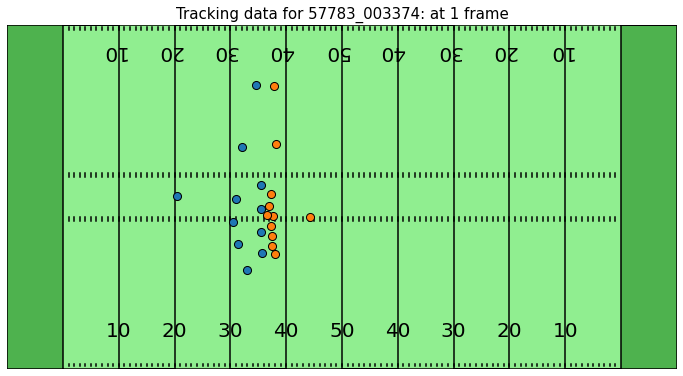

In [33]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pylab as plt

def find_nearest(array, value):
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def create_football_field(
    linenumbers=True,
    endzones=True,
    highlight_line=False,
    highlight_line_number=50,
    highlighted_name="Line of Scrimmage",
    fifty_is_los=False,
    figsize=(12, 6.33),
    field_color="lightgreen",
    ez_color='forestgreen',
    ax=None,):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle(
        (0, 0),
        120,
        53.3,
        linewidth=0.1,
        edgecolor="r",
        facecolor=field_color,
        zorder=0,
    )

    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='black')

    if fifty_is_los:
        ax.plot([60, 60], [0, 53.3], color="gold")
        ax.text(62, 50, "<- Player Yardline at Snap", color="gold")
    # Endzones
    if endzones:
        ez1 = patches.Rectangle(
            (0, 0),
            10,
            53.3,
            linewidth=0.1,
            edgecolor="black",
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ez2 = patches.Rectangle(
            (110, 0),
            120,
            53.3,
            linewidth=0.1,
            edgecolor="black",
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    ax.axis("off")
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            ax.text(
                x,
                5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color="black",
            )
            ax.text(
                x - 0.95,
                53.3 - 5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color="black",
                rotation=180,
            )
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color="black")
        ax.plot([x, x], [53.0, 52.5], color="black")
        ax.plot([x, x], [22.91, 23.57], color="black")
        ax.plot([x, x], [29.73, 30.39], color="black")

    if highlight_line:
        hl = highlight_line_number + 10
        ax.plot([hl, hl], [0, 53.3], color="yellow")
        ax.text(hl + 2, 50, "<- {}".format(highlighted_name), color="yellow")

    border = patches.Rectangle(
        (-5, -5),
        120 + 10,
        53.3 + 10,
        linewidth=0.1,
        edgecolor="orange",
        facecolor="white",
        alpha=0,
        zorder=0,
    )
    ax.add_patch(border)
    ax.set_xlim((0, 120))
    ax.set_ylim((0, 53.3))
    return ax


# game_play = "57783_003374"
# example_tracks = tracking.query("game_play == @game_play and isSnap == True")

nearest_frame_tracking = find_nearest(tracking['est_frame'].values, frames_print[0]) # Находим предполагаемый кадр из трека по номеру кадра
tracking_posit = tracking[tracking['est_frame']==nearest_frame_tracking].copy() # трек предполагаемого кадра

example_tracks =  tracking.loc[(tracking['est_frame'] == 4) & (tracking['game_play'] == game_play)]
ax = create_football_field()
for team, d in example_tracks.groupby("team"):
    ax.scatter(d["x"], d["y"], label=team, s=65, lw=1, edgecolors="black", zorder=5)
ax.legend().remove()
ax.set_title(f"Tracking data for {game_play}: at {frames_print[0]} frame", fontsize=15)
plt.show()

# def dots():

In [ ]:
def dots(game_play, baseline_boxes, gt_labels, tracking, frame, home_color="red", away_color="white"): # номер игры, боксы, лэйблы, трекинг и номер кадра

    baseline_boxes['game_play'] = baseline_boxes['video_frame'].map(lambda x: '_'.join(str(x).split('_')[:2]))
    baseline_boxes['frame'] = baseline_boxes['video_frame'].map(lambda x: int(str(x).split('_')[-1]))
    baseline_boxes['zone'] = baseline_boxes['video_frame'].map(lambda x: str(x).split('_')[-2])
    
    ez = "Endzone"
    sd = "Sideline"
    game_play_boxes_endzone = baseline_boxes.query("game_play == @game_play and frame == @frame and zone == @ez").reset_index(drop=True)
    game_play_boxes_sideline = baseline_boxes.query("game_play == @game_play and frame == @frame and zone == @sd").reset_index(drop=True)
    
    cap = cv2.VideoCapture(f"{ENTRY}/nfl-health-and-safety-helmet-assignment/train/{game_play}_Endzone.mp4")
    cap.set(1, frame-1)
    _, image_endzone = cap.read()
    cap = cv2.VideoCapture(f"{ENTRY}/nfl-health-and-safety-helmet-assignment/train/{game_play}_Sideline.mp4")
    cap.set(1, frame-1)
    _, image_sideline = cap.read()
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))
    
    game_play_tracking = tracking.query("game_play == @game_play").reset_index(drop=True)
    closest_tracking_frame = game_play_tracking.iloc[(game_play_tracking['est_frame']-frame).abs().argsort()[0]]['est_frame']
    game_play_tracking = game_play_tracking.query("est_frame == @closest_tracking_frame").reset_index(drop=True)
    
    image_endzone_black = image_endzone*0
    image_sideline_black = image_sideline*0
    
    color = (255, 255, 255)
    
    # Now, add the boxes
    for box in game_play_boxes_endzone.itertuples(index=False):
        cv2.rectangle(
            image_endzone,
            (box.left, box.top),
            (box.left + box.width, box.top + box.height),
            color,
            thickness=1,
        )
        cv2.putText(
            image_endzone,
            f"{box.conf:0.2}",
            (box.left, max(0, box.top - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            thickness=1,
        )
        cv2.circle(image_endzone_black, (box.left + box.width//2 ,box.top + box.height//2), radius=5, color=color, thickness=-1)
    
    for box in game_play_boxes_sideline.itertuples(index=False):
        cv2.rectangle(
            image_sideline,
            (box.left, box.top),
            (box.left + box.width, box.top + box.height),
            color,
            thickness=1,
        )
        cv2.putText(
            image_sideline,
            f"{box.conf:0.2}",
            (box.left, max(0, box.top - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            thickness=1,
        )
        cv2.circle(image_sideline_black, (box.left + box.width//2 ,box.top + box.height//2), radius=5, color=color, thickness=-1)
    
    axs[0, 0].imshow(cv2.cvtColor(image_sideline, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis("off")
    axs[0, 0].set_title(f"{game_play}_Endzone_{frame}", fontsize=20)
    axs[0, 1].imshow(cv2.cvtColor(image_endzone, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title(f"{game_play}_Sideline_{frame}", fontsize=20)
    axs[0, 1].axis("off")
    axs[1, 0].imshow(cv2.cvtColor(image_sideline_black, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis("off")
    axs[1, 0].set_title(f"{game_play}_Endzone_{frame}", fontsize=20)
    axs[1, 1].imshow(cv2.cvtColor(image_endzone_black, cv2.COLOR_BGR2RGB))
    axs[1, 1].set_title(f"{game_play}_Sideline_{frame}", fontsize=20)
    axs[1, 1].axis("off")
    plt.tight_layout()
    
    ax = create_football_field()
    team_to_color = {"Home" : "red", "Away" : "white"}
    for team, d in game_play_tracking.groupby("team"):
        ax.scatter(d["x"], d["y"], label=team, s=65, lw=1, edgecolors="black", zorder=5, color=team_to_color[team])
    ax.legend().remove()
    ax.set_title(f"Tracking data for {game_play}: at {closest_tracking_frame}", fontsize=15)
    plt.show()

    return game_play_boxes_endzone, game_play_boxes_sideline, game_play_tracking

In [ ]:
def score_on_video(myvideo, preds, labels):
    myvideo_mp4 = myvideo + '.mp4'
    labels_video = labels.query('video == @myvideo_mp4')
    scorer = NFLAssignmentScorer(labels_video)
    video_score = scorer.score(preds)
    print(f'score: {video_score:0.5f}')
    
def score_on_all_videos(preds, labels):
    scorer = NFLAssignmentScorer(labels)
    video_score = scorer.score(preds)
    print(f'score: {video_score:0.5f}')